## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras._tf_keras.keras import layers, models
from keras._tf_keras.keras.models import Sequential

## Set Constant Values

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

## Download or load the dataset 

In [3]:
training = "Data/Corn leaf deseases/train/"
testing = "Data/Corn leaf deseases/test/"

## Image Preprocessing

### Create Dataset for train,test,validation

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 3348 files belonging to 4 classes.
Using 2679 files for training.
['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__debug_string__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__tf_tracing_type__', '__weakref__', '_abc_impl', '_add_trackable_child', '_add_variable_with_custom_getter', '_apply_debug_options', '_as_serialized_graph', '_buffer_size', '_checkpoint_adapter', '_checkpoint_dependencies', '_common_args', '_consumers', '_convert_variables_to_tensors', '_copy_trackable_to_cpu', '_deferred_dependencies', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_f

In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testing,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 840 files belonging to 4 classes.
Using 168 files for validation.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 3348 files belonging to 4 classes.
Using 669 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


## Visualize the data

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure the dataset for performance

In [9]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.93725413


## Resize and Rescale

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(0.1 / 256)
])

## Data Augmentation

In [13]:
data_augmentation  = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

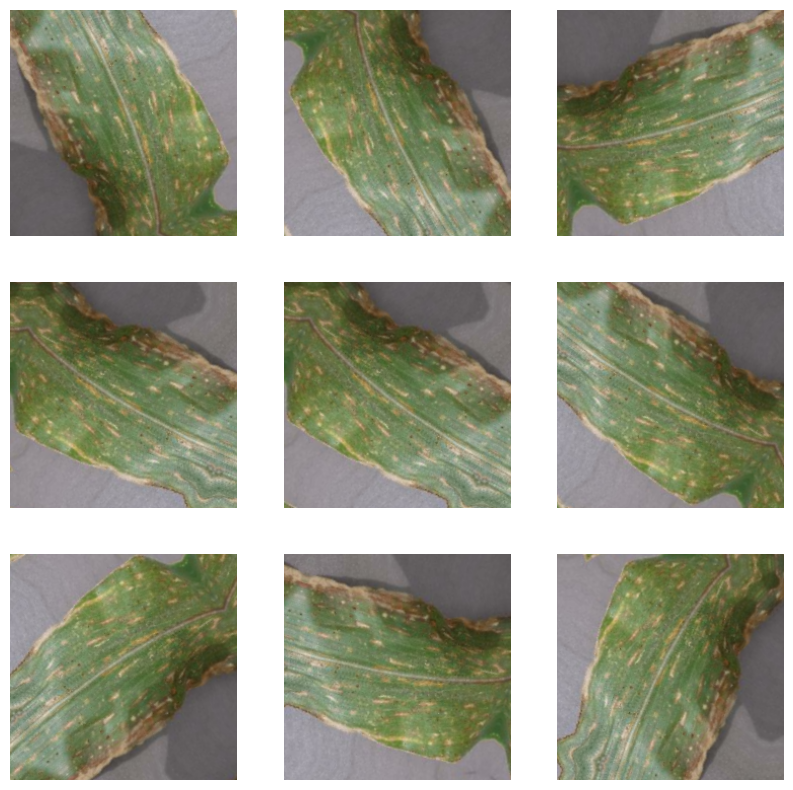

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# EfficientNet Model Implementation

Import the base model

In [16]:
from keras._tf_keras.keras.applications.efficientnet_v2 import EfficientNetV2B0

Create a base model

In [18]:
conv_base = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
)
conv_base.trainable = False

In [19]:
from keras._tf_keras.keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras._tf_keras.keras.losses import SparseCategoricalCrossentropy
from keras._tf_keras.keras.callbacks import EarlyStopping

Add Connected layers to VGG16 Base

In [20]:
model_eff = Sequential()
resize_and_rescale
model_eff.add(conv_base)
model_eff.add(Flatten())
model_eff.add(Dense(256,activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(BatchNormalization())
model_eff.add(Dense(num_classes,activation='sigmoid'))
model_eff.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,977,940 (83.84 MB)

 Trainable params: 16,058,116 (61.26 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

Add early_stopping

In [21]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your goal
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

Compile the model

In [22]:
model_eff.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Train the model

In [23]:
epochs = 5
history = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8051 - loss: 0.5522 - val_accuracy: 0.8984 - val_loss: 0.2705
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8878 - loss: 0.2962 - val_accuracy: 0.9088 - val_loss: 0.2182
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9091 - loss: 0.2340 - val_accuracy: 0.9312 - val_loss: 0.1665
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9266 - loss: 0.1990 - val_accuracy: 0.9268 - val_loss: 0.1854
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9330 - loss: 0.1826 - val_accuracy: 0.9357 - val_loss: 0.1449
Restoring model weights from the end of the best epoch: 5.


### Evaluate the model

In [24]:
model_eff.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - accuracy: 0.9433 - loss: 0.1615


[0.15008193254470825, 0.9523809552192688]

# Visualize training results

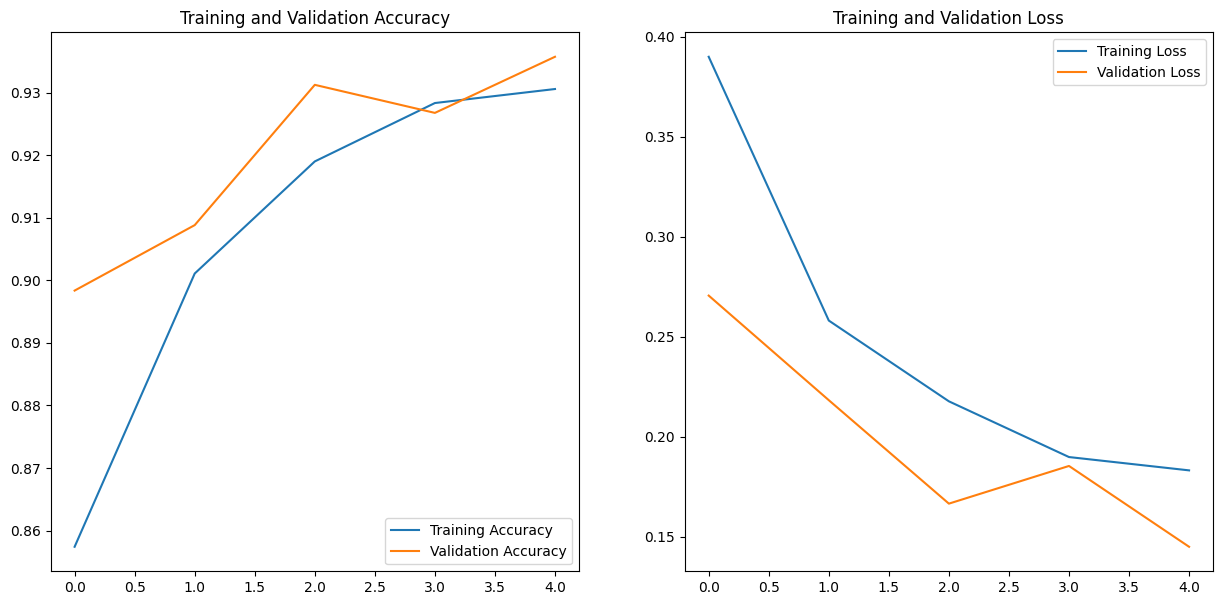

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

In [26]:
model_eff.save("Model EfficientNet.keras")

In [20]:
from keras._tf_keras.keras.applications import DenseNet121, InceptionV3
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# DenseNet Model Implementation

In [20]:
model_dense = Sequential()
resize_and_rescale
model_dense.add(base_model)
model_dense.add(Flatten())
model_dense.add(Dense(256,activation='relu'))
model_dense.add(Dropout(0.5))
model_dense.add(BatchNormalization())
model_dense.add(Dense(num_classes,activation='sigmoid'))
model_dense.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,884,354 (75.85 MB)

 Trainable params: 12,846,338 (49.00 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [21]:
model_dense.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [23]:
epochs = 5
history = model_dense.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 741s 3s/step - accuracy: 0.5683 - loss: 0.8179 - val_accuracy: 0.6154 - val_loss: 0.6459
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 612s 3s/step - accuracy: 0.6211 - loss: 0.6499 - val_accuracy: 0.6496 - val_loss: 0.6233
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.6395 - loss: 0.6268 - val_accuracy: 0.6282 - val_loss: 0.6388
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.6416 - loss: 0.6287 - val_accuracy: 0.6709 - val_loss: 0.6023
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.6404 - loss: 0.6282 - val_accuracy: 0.6838 - val_loss: 0.6053
Restoring model weights from the end of the best epoch: 4.


Evaluate the model

In [24]:
model_dense.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6693 - loss: 0.6207


[0.6391549110412598, 0.6538461446762085]

Visualize training accuracy and loss

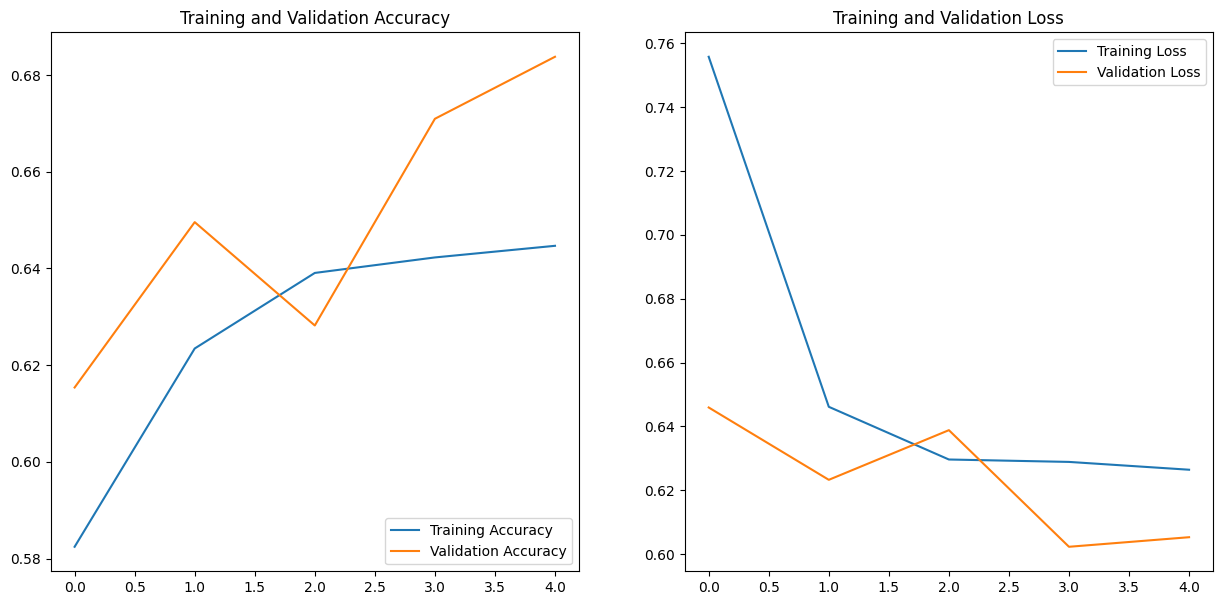

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Save the model

In [26]:
model_dense.save('Model DenseNet.keras')

# InceptionV3 Model Implementation

In [21]:
base_inc = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_inc.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [22]:
model_inc = Sequential()
resize_and_rescale
model_inc.add(base_inc)
model_inc.add(Flatten())
model_inc.add(Dense(256,activation='relu'))
model_inc.add(Dropout(0.5))
model_inc.add(BatchNormalization())
model_inc.add(Dense(num_classes,activation='sigmoid'))
model_inc.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,911,778 (133.18 MB)

 Trainable params: 13,108,482 (50.00 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

In [23]:
model_inc.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [25]:
epochs = 10
history = model_inc.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.5522 - loss: 0.7816 - val_accuracy: 0.6026 - val_loss: 0.6790
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.5869 - loss: 0.6887 - val_accuracy: 0.6239 - val_loss: 0.6446
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.5975 - loss: 0.6662 - val_accuracy: 0.6154 - val_loss: 0.6479
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.5979 - loss: 0.6675 - val_accuracy: 0.6282 - val_loss: 0.6543
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.5931 - loss: 0.6699 - val_accuracy: 0.5684 - val_loss: 0.6759
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


Evaluate the model

In [26]:
model_inc.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6397 - loss: 0.6500


[0.6356950998306274, 0.6581196784973145]

Visualize training accuracy and losses

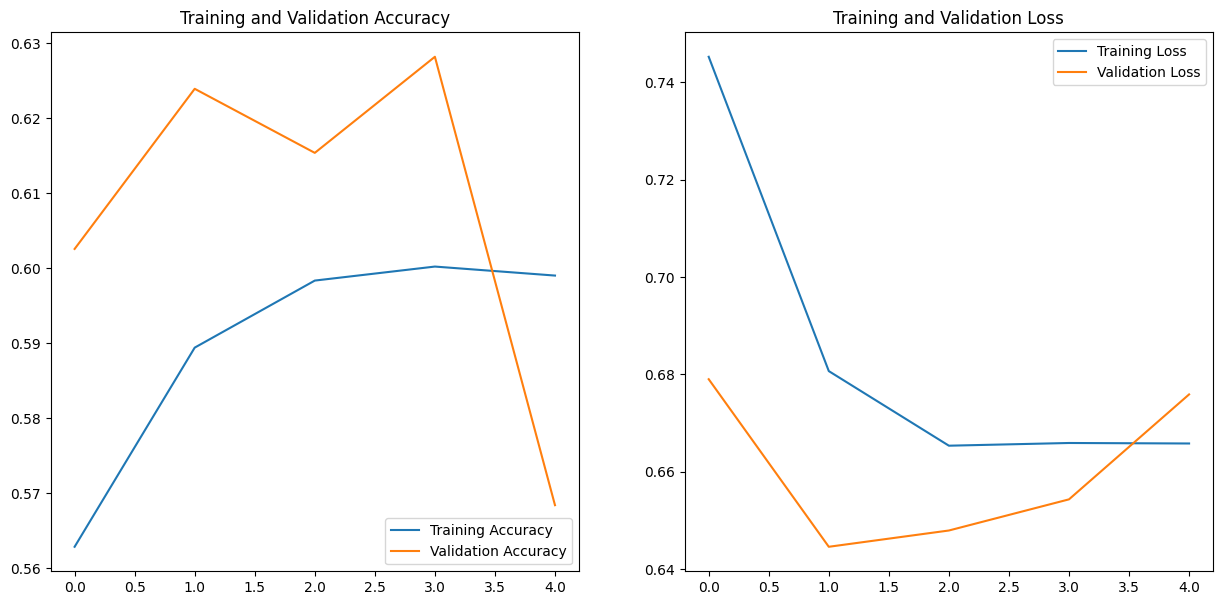

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Save the model

In [30]:
model_inc.save('Model InceptionV3.keras')